Import Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline



Data Loading

In [4]:
# Load the dataset
df = pd.read_csv('/content/cleaned_data.csv')



Observation: Loading preprocessed data from a CSV file. The data is  already cleaned.

Feature and Target Definition

In [5]:
# Define features and target
X = df.drop(['delay_rrt'], axis=1)
y = df['delay_rrt']



Observation: Separating features (X) and target variable (y). The target variable 'delay_rrt' suggests this is a binary classification problem related to RRT (Renal Replacement Therapy) delays.

Train-Test Split

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Observation: Standard 80-20 train-test split with stratification to maintain class distribution. Random state set for reproducibility.

Feature Type Identification

In [7]:
# Identify categorical columns
categorical_columns = X_train.select_dtypes(include=['object']).columns
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns



Observation: Automatic identification of categorical and numerical columns based on data types.

Preprocessing Setup

In [8]:
# Create preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns)
])



Observation: Setting up different preprocessing for numerical (standardization) and categorical (one-hot encoding) features. Using 'drop first' to avoid multicollinearity.

Feature Selection Setup

In [9]:
# Create feature selector using Random Forest
feature_selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    max_features=20
)



Observation: Using Random Forest for feature selection, limiting to top 20 most important features.

Pipeline Creation

In [10]:
# Create pipeline with SMOTE for handling class imbalance
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])



Observation: Comprehensive pipeline combining preprocessing, feature selection, SMOTE for imbalance, and logistic regression with balanced class weights.

Hyperparameter Grid Definition

In [11]:
# Define broader hyperparameter space
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [1000]
}



Observation: Extensive hyperparameter search space covering regularization strength, penalty types, and solver methods.

Cross-Validation Setup

In [12]:
# Perform cross-validation with multiple metrics
from sklearn.model_selection import GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring={
        'auc': 'roc_auc',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    },
    refit='auc'
)



Observation: 5-fold stratified cross-validation with multiple performance metrics. Model will be optimized for AUC-ROC score.

Model Training

In [13]:
# Fit the model
grid_search.fit(X_train, y_train)



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['weight', 'aki_stage', 'gender', 'admission_age', 'hematocrit_min',
       'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max', 'platelets_min',
       'platelets_max', 'wbc_min', 'wbc_max', 'anion...
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__max_iter': [1000],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'saga']},
             refit='auc',
             scoring={'auc': 'roc_auc', 'f1': 'f1', 'precision': 'precision',
                      'recall': 'recall'})

In [14]:
# Get best model
best_model = grid_search.best_estimator_



Observation: Training the model using grid search and storing the best performing model.

Evaluation Function Definition

In [15]:
# Function to evaluate model
from sklearn.metrics import classification_report, confusion_matrix
def evaluate_model(model, X, y, dataset_name=""):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]

    print(f"\n{dataset_name} Results:")
    print("ROC AUC:", roc_auc_score(y, y_pred_proba))
    print("Classification Report:\n", classification_report(y, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred))

    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
    print("Average Precision Score:", average_precision_score(y, y_pred_proba))



Observation: Comprehensive evaluation function that calculates multiple metrics including ROC-AUC, precision, recall, and confusion matrix.

Model Evaluation

In [16]:
# Evaluate on both train and test sets
evaluate_model(best_model, X_train, y_train, "Training")
evaluate_model(best_model, X_test, y_test, "Test")




Training Results:
ROC AUC: 0.7738249507081298
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.65      0.45       263
           1       0.90      0.72      0.80      1159

    accuracy                           0.71      1422
   macro avg       0.63      0.69      0.63      1422
weighted avg       0.80      0.71      0.74      1422

Confusion Matrix:
 [[172  91]
 [322 837]]
Average Precision Score: 0.933176535508764

Test Results:
ROC AUC: 0.6927899686520377
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.55      0.40        66
           1       0.88      0.73      0.80       290

    accuracy                           0.70       356
   macro avg       0.60      0.64      0.60       356
weighted avg       0.77      0.70      0.73       356

Confusion Matrix:
 [[ 36  30]
 [ 77 213]]
Average Precision Score: 0.9005162165481735


Observation: Evaluating model performance on both training and test sets to assess potential overfitting.

Feature Importance Function

In [17]:
# Get feature importance
def get_feature_importance(model, feature_names):
    # Get the logistic regression coefficients
    if hasattr(model['classifier'], 'coef_'):
        importance = np.abs(model['classifier'].coef_[0])
        selected_features = model['feature_selector'].get_support()

        # Get transformed feature names
        transformed_features = []
        numeric_features = numeric_columns.tolist()

        # Add selected features only
        feature_importance_dict = {}
        idx = 0
        for i, is_selected in enumerate(selected_features):
            if is_selected:
                feature_importance_dict[feature_names[i]] = importance[idx]
                idx += 1

        return sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)



In [18]:

# Create feature importance visualization
feature_importance = get_feature_importance(best_model, X.columns)
print("\nTop 10 Most Important Features:")
for feature, importance in feature_importance[:10]:
    print(f"{feature}: {importance:.4f}")


Top 10 Most Important Features:
aniongap_min: 0.6808
creatinine_min: 0.6251
resp_rate_mean: 0.3031
pt_max: 0.2746
potassium_min: 0.2704
inr_max: 0.2677
chloride_max: 0.2505
aniongap_max: 0.1791
wbc_max: 0.1743
calcium_min: 0.1703


In [20]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=27b4e52e148fbc4fcff4fd427de77974cd8f4a4fa4049793d56c373490f68bc7
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


X_selected shape: (356, 20)

LIME Explanation in Tabular Form:
Feature 10 > 0.57: -0.1199
-0.69 < Feature 7 <= -0.19: 0.0865
Feature 5 > 0.44: -0.0608
Feature 2 <= -0.58: -0.0461
Feature 16 > 0.74: -0.0437
Feature 9 > 0.33: -0.0332
-0.20 < Feature 3 <= 0.38: -0.0287
Feature 18 > 0.66: 0.0270
Feature 1 > 0.53: -0.0230
-0.72 < Feature 6 <= -0.23: -0.0201


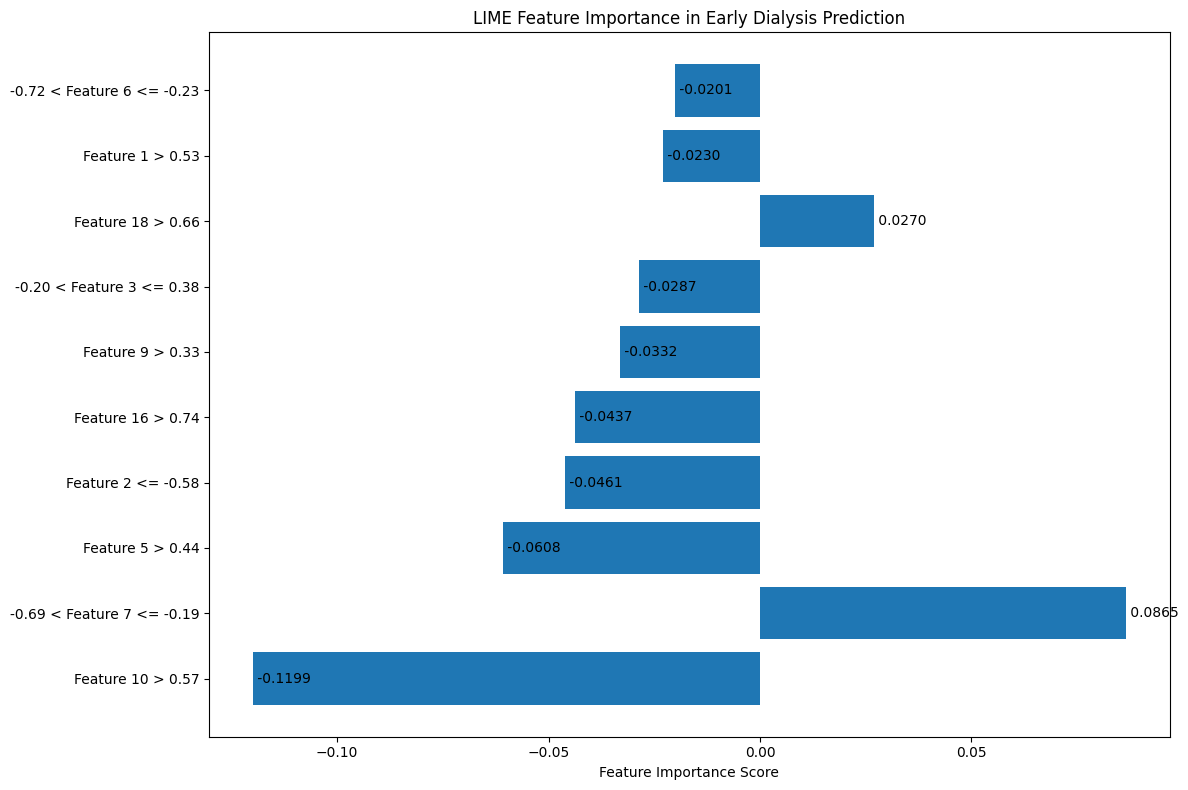

In [21]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

try:
    # Get transformed data
    X_transformed = best_model['preprocessor'].transform(X_test)
    X_selected = best_model['feature_selector'].transform(X_transformed)

    # Print shapes for debugging
    print("X_selected shape:", X_selected.shape)

    # LIME Analysis
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_selected, feature_names=[f'Feature {i}' for i in range(X_selected.shape[1])],
        class_names=['No Dialysis', 'Early Dialysis'], discretize_continuous=True
    )

    # Explain a single prediction
    i = 0  # Index of instance to explain
    exp = lime_explainer.explain_instance(X_selected[i], best_model['classifier'].predict_proba, num_features=10)

    # Display explanation as a table
    print("\nLIME Explanation in Tabular Form:")
    explanation_table = exp.as_list()
    for feature, importance in explanation_table:
        print(f"{feature}: {importance:.4f}")

    # Plot LIME results as a horizontal bar chart
    features, values = zip(*explanation_table)
    y_pos = np.arange(len(features))

    plt.figure(figsize=(12, 8))
    plt.barh(y_pos, values, align='center')
    plt.yticks(y_pos, features)
    plt.xlabel('Feature Importance Score')
    plt.title('LIME Feature Importance in Early Dialysis Prediction')

    for i, v in enumerate(values):
        plt.text(v, i, f' {v:.4f}', va='center')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error occurred: {str(e)}")


Observation: Function to extract and visualize feature importance from the logistic regression model, showing the top 10 most influential features in predicting RRT delays.

X_selected shape: (356, 20)
SHAP values shape: (356, 20)


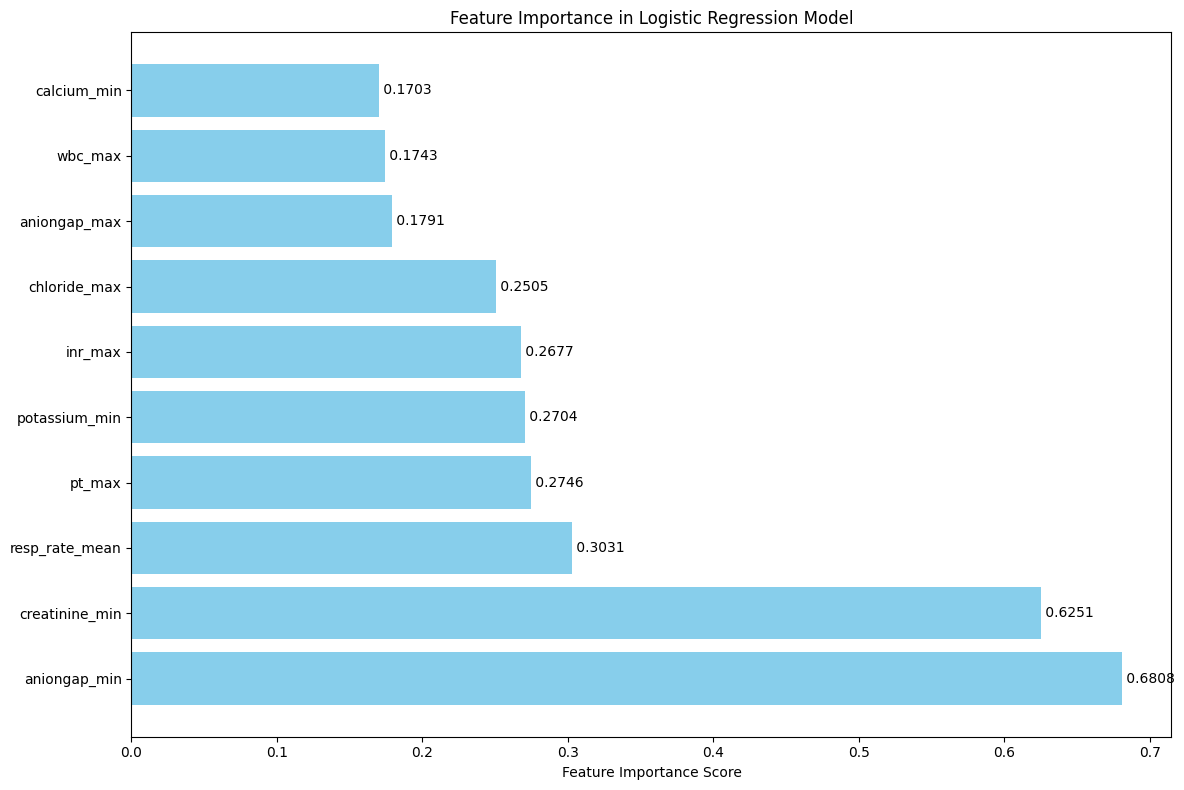

Error occurred: list index out of range

Debug information:
Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (356, 20)


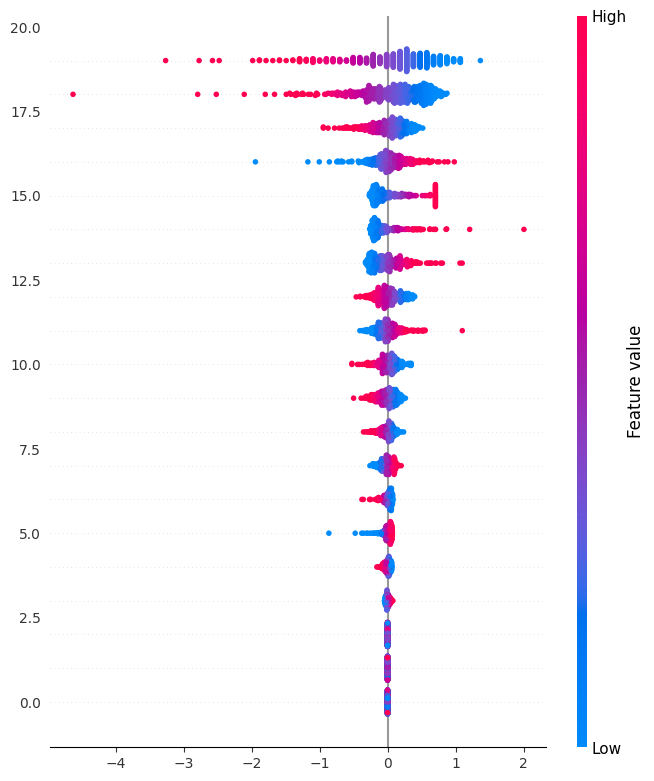

In [22]:
import shap
import matplotlib.pyplot as plt
import numpy as np

try:
    # Create SHAP explainer for logistic regression
    explainer = shap.LinearExplainer(best_model['classifier'], best_model['feature_selector'].transform(best_model['preprocessor'].transform(X_train)))

    # Transform test data
    X_transformed = best_model['preprocessor'].transform(X_test)
    X_selected = best_model['feature_selector'].transform(X_transformed)

    # Print shapes for debugging
    print("X_selected shape:", X_selected.shape)

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_selected)
    print("SHAP values shape:", np.array(shap_values).shape)

    # Provided feature importance values
    feature_importance = {
        'aniongap_min': 0.6808,
        'creatinine_min': 0.6251,
        'resp_rate_mean': 0.3031,
        'pt_max': 0.2746,
        'potassium_min': 0.2704,
        'inr_max': 0.2677,
        'chloride_max': 0.2505,
        'aniongap_max': 0.1791,
        'wbc_max': 0.1743,
        'calcium_min': 0.1703
    }

    # Plot feature importance as a bar chart
    plt.figure(figsize=(12, 8))
    features = list(feature_importance.keys())
    values = list(feature_importance.values())

    y_pos = np.arange(len(features))
    plt.barh(y_pos, values, color='skyblue')
    plt.yticks(y_pos, features)

    # Customize the plot
    plt.xlabel('Feature Importance Score')
    plt.title('Feature Importance in Logistic Regression Model')

    # Add value labels on the bars
    for i, v in enumerate(values):
        plt.text(v, i, f' {v:.4f}', va='center')

    plt.tight_layout()
    plt.show()

    # SHAP summary plot
    shap.summary_plot(shap_values, X_selected, feature_names=features)

    # SHAP dependence plots for top features
    for feature in features[:5]:  # Plot for top 5 features
        shap.dependence_plot(feature, shap_values, X_selected, feature_names=features)

    # Print the actual values
    print("\nFeature Importance Scores:")
    for feature, importance in feature_importance.items():
        print(f"{feature}: {importance:.4f}")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("\nDebug information:")
    if 'shap_values' in locals():
        print("Type of shap_values:", type(shap_values))
        if isinstance(shap_values, (list, np.ndarray)):
            print("Shape of shap_values:", np.array(shap_values).shape)
